# Imports

In [1]:
import math
import pandas as pd
import numpy as np
import madmom as mm
import librosa as lr
import pretty_midi as pm
import librosa.display as display
import IPython.display as ipd
import matplotlib.pyplot as plt

# Constants

In [2]:
# DATAPOINT = "../datasets/maps/CH/" + \
#             "MAPS_ISOL_CH0.1_F_SptkBGAm.wav"
# MIDI_DATAPOINT = "../datasets/maps/CH/" + \
#         "MAPS_ISOL_CH0.1_F_SptkBGAm.mid"

DATAPOINT = "../datasets/maps/C0-1-3-4-8/" + \
            "MAPS_UCHO_C0-1-3-4-8_I32-96_S0_n1_ENSTDkAm.wav"
MIDI_DATAPOINT = "../datasets/maps/C0-1-3-4-8/" + \
        "MAPS_UCHO_C0-1-3-4-8_I32-96_S0_n1_ENSTDkAm.mid"

# Wrangle Data
(load datapoint)

In [3]:
timeSeries, sampleRate = lr.load(DATAPOINT)

In [4]:
sampleRate

22050

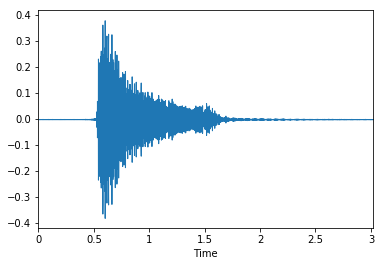

In [5]:
display.waveplot(timeSeries, sr=sampleRate)

In [6]:
ipd.Audio(timeSeries, rate=sampleRate)

# Spectrogramify

### CQT Form

In [7]:
cqtSpect = lr.cqt(timeSeries,
                  fmin=lr.midi_to_hz(21),
                  sr=sampleRate,
                  hop_length=512,
                  bins_per_octave=16, # "resolution within an 8ve"
                  n_bins=16 * 8)      # number of total bins
                 

/anaconda2/lib/python2.7/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/anaconda2/lib/python2.7/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


In [8]:
cqtSpect.T.shape

(131, 128)

In [9]:
lr.midi_to_hz(21), lr.midi_to_hz(21 + 12 * 8)

(array([27.5]), array([7040.]))

/anaconda2/lib/python2.7/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


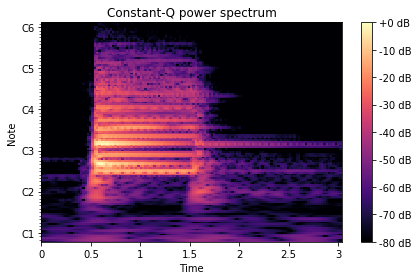

In [10]:
lr.display.specshow(lr.amplitude_to_db(cqtSpect, ref=np.max), \
                    sr=sampleRate, x_axis='time', y_axis='cqt_note', fmin=lr.midi_to_hz(21), bins_per_octave=24)
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

In [11]:
# lr.display.specshow?

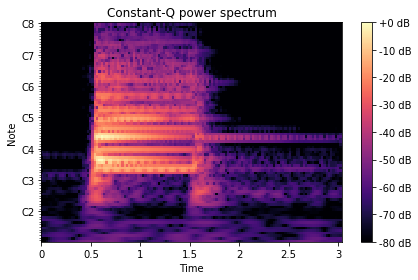

In [12]:
y, sr = lr.load(DATAPOINT)
C = lr.cqt(y, sr=sr)
lr.display.specshow(lr.amplitude_to_db(C, ref=np.max), \
                    sr=sampleRate, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

In [13]:
C.T.shape

(131, 84)

Generate ground truths:
+ Create ground truth range 
  --> SR from MAPS, Hop Length from...
  --> t = HL/SR
  --> np.arange(Num of Frames (from above)) * t

### STFT + Triangular Filterbank form

In [14]:
signal = mm.audio.signal.Signal(DATAPOINT, num_channels=1)
framedSignal = mm.audio.signal.FramedSignal(signal, frame_size=2048, hop_size=441)

In [15]:
signal.sample_rate

44100

In [83]:
stfttri = mm.audio.spectrogram.LogarithmicFilteredSpectrogram(
    DATAPOINT,
    num_bands=48,
    num_channels=1, 
    sr=44100,
    unique_filters=True,
    norm_filters=True,
    frame_size=4096,
    fft_size=4096,
#     fps=31.25,
    fmin=30,
    fmax=8000.0,
    fref=440.0,
    circular_shift=False,
    hop_size=441.0)

In [84]:
print stfttri.min()
print stfttri.max()

5.2289342e-06
2.176985


In [85]:
stfttri = np.array(stfttri)
stfttri = lr.util.normalize(stfttri, norm=np.inf)

In [86]:
stfttri

array([[0.09194888, 0.13948144, 0.06741225, ..., 0.06489189, 0.15797357,
        0.01337499],
       [0.06142711, 0.18317827, 0.08189944, ..., 0.0841903 , 0.17088213,
        0.01805772],
       [0.0422181 , 0.21452932, 0.082886  , ..., 0.09150521, 0.16914132,
        0.02186319],
       ...,
       [0.08445238, 0.12344123, 0.03594102, ..., 0.05604115, 0.19906209,
        0.02358392],
       [0.11287632, 0.13563476, 0.05382819, ..., 0.05507206, 0.20556475,
        0.02271657],
       [0.13089533, 0.13271038, 0.0618577 , ..., 0.05335998, 0.18431558,
        0.02072065]])

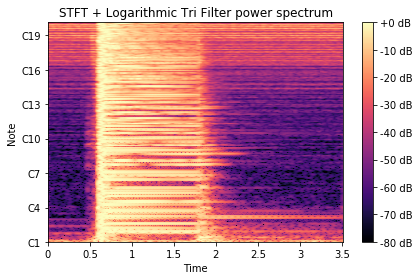

In [87]:
lr.display.specshow(
    lr.amplitude_to_db(stfttri, ref=np.max).T, 
    sr=44100,
    x_axis='time',
    y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT + Logarithmic Tri Filter power spectrum')
plt.tight_layout()

### Generate Ground Truths

For each column in transform
- Reshape.
  - np.abs, rescale to (0 to 1)
- Generate ground truth array
  - Times = np.arange(Nframes) * t
    - Where t = hopLength/sampleRate
  - Use associative .txt to check which pitches are on or off.
  - Output ground truth array with which notes are on or off
    - i.e. [0, 1, 0 , 0 , 0...]

Pad and Create Window

In [88]:
testArray = np.array([[1, 2],[3, 4]])
testArray

array([[1, 2],
       [3, 4]])

In [89]:
np.pad(testArray, ((1, 1), (0, 0)), 'constant')

array([[0, 0],
       [1, 2],
       [3, 4],
       [0, 0]])

(num_of_bins, time_steps)

In [90]:
times = lr.frames_to_time(
    np.arange(stfttri.shape[0]),
    sr=44100,
    hop_length=441.0
)

In [91]:
midi = pm.PrettyMIDI(MIDI_DATAPOINT)

In [92]:
expectedOutput = midi.get_piano_roll(fs=44100, times=times)[21:108+1].T
expectedOutput[expectedOutput > 0] = 1

In [93]:
expectedOutput[expectedOutput > 0] = 1

#### Sanity Check spectrogram + expected:

In [94]:
print stfttri.shape
print expectedOutput.shape
print times.shape

(303, 229)
(303, 88)
(303,)


In [95]:
test_ticks = range(95,95+95)

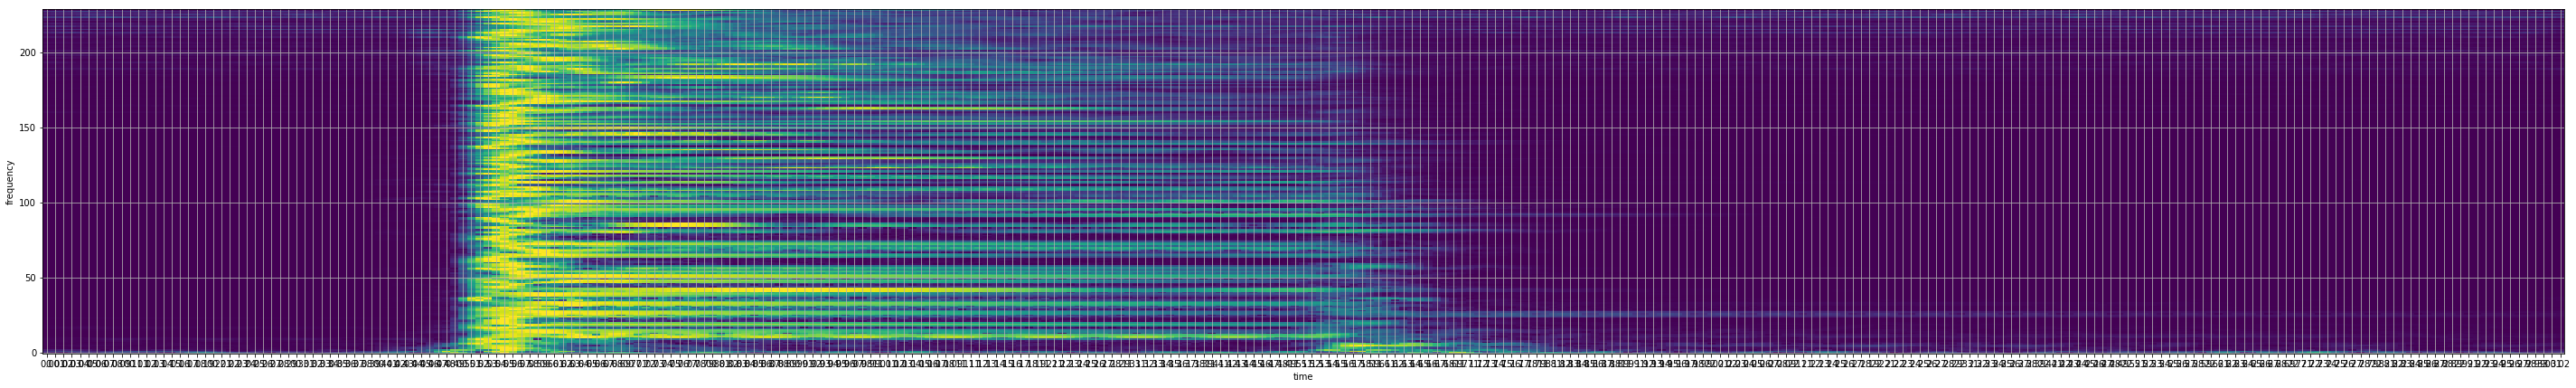

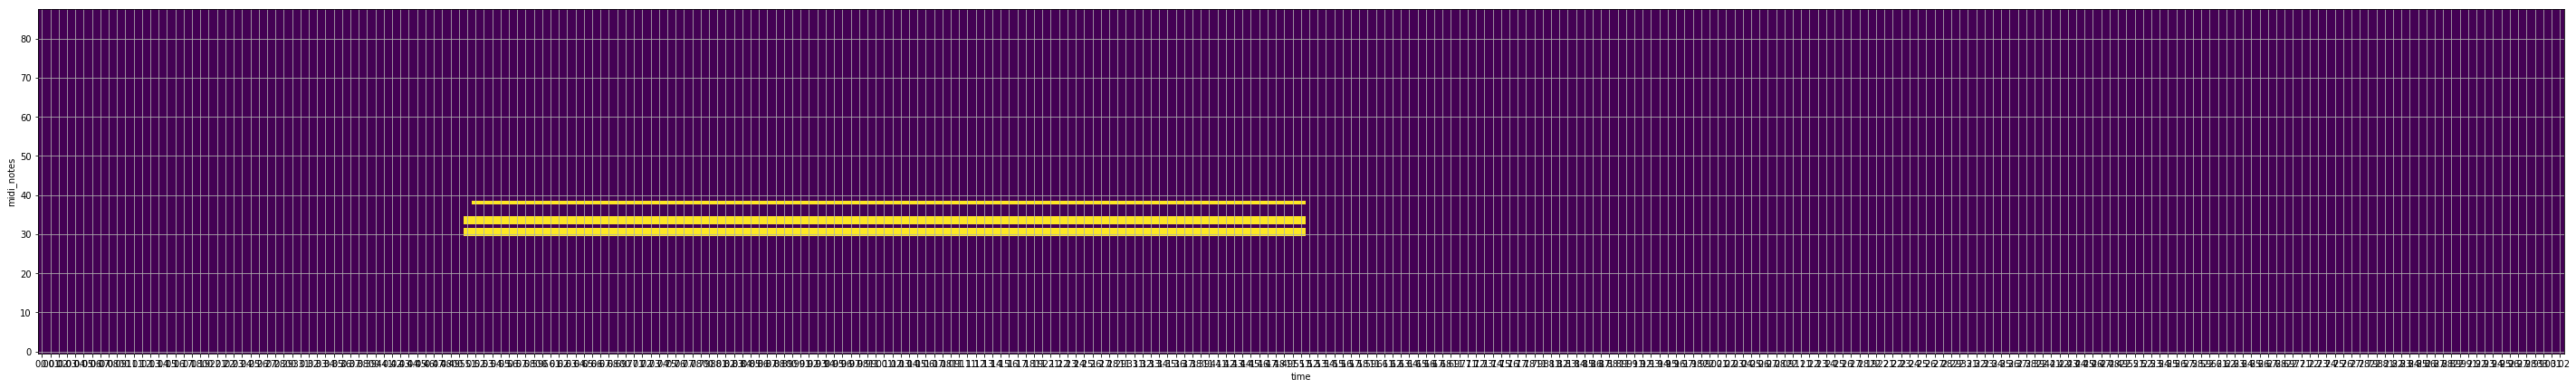

In [96]:
length = 50
time_locs = range(stfttri.shape[0])

fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(stfttri.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('frequency')
plt.xticks(time_locs, times)
# plt.savefig('spect.png')
plt.show()
fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(expectedOutput.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.xticks(time_locs, times)
# plt.savefig('ground.png')
plt.show()

## HCQT Form

In [30]:
def get_hcqt_params():
    """Hack to always use the same parameters :)
    """
    bins_per_octave = 60
    n_octaves = 6
    harmonics = [0.5, 1, 2, 3, 4, 5]
    sr = 22050
    fmin = 32.7
    hop_length = 256
    return bins_per_octave, n_octaves, harmonics, sr, fmin, hop_length

def compute_hcqt(path):
    (bins_per_octave, n_octaves, harmonics,
     sr, f_min, hop_length) = get_hcqt_params()
    
    y, fs = lr.load(path, sr=sr)
    
    cqt_list = []
    shapes = []
    for h in harmonics:
        cqt = lr.cqt(
                y,
                sr=fs,
                hop_length=hop_length,
                fmin=f_min*float(h),
                n_bins=bins_per_octave*n_octaves,
                bins_per_octave=bins_per_octave)
        cqt_list.append(cqt)
        shapes.append(cqt.shape)
    
    shapes_equal = [s == shapes[0] for s in shapes]
    if not all(shapes_equal):
        min_time = np.min([s[1] for s in shapes])
        new_cqt_list = []
        for i in range(len(cqt_list)):
            new_cqt_list.append(cqt_list[i][:, :min_time])
        cqt_list = new_cqt_list
        
    log_hcqt = ((1.0/80.0) * lr.core.amplitude_to_db(
        np.abs(np.array(cqt_list)), ref=np.max)) + 1.0
    return log_hcqt

In [31]:
log_hcqt = compute_hcqt(DATAPOINT)

In [32]:
"harmonics, time, frequencies"
log_hcqt.shape

(6, 360, 261)

In [33]:
array = np.array([[1, 2], [1, 2], [1, 2]])
array.shape

(3, 2)

'MIN_MIDI' : 21,
'MAX_MIDI' : 108,

In [34]:
print lr.midi_to_hz(21)
print lr.midi_to_hz(108)
print lr.hz_to_note(lr.midi_to_hz(21))
print lr.hz_to_note(lr.midi_to_hz(108))

[27.5]
[4186.00904481]
['A0']
['C8']
